# Yield-Enhanced FX Strategies for G10 Currencies

### Import data and set parameters

In [1]:
import pandas as pd
import numpy as np
from operator import sub
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import cvxpy as cp
from pandas.tseries.offsets import BMonthEnd
from pandas.tseries.offsets import BQuarterEnd

In [2]:
plt.rcParams['figure.figsize'] = (15,8)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'

In [3]:
TRANS_FEE= 0.0002

### Import Source files for Pair Trading and Momentum

In [4]:
s_rate=pd.read_excel("G10_FX_SPOT.xlsx",index_col=0)

fx_df = pd.read_csv("G10_FX_HI_LO_CLOSE.csv", skiprows=0, header = None)

namelist = ['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF', 'DKK', 'NOK', 'SEK']
base = s_rate['EUR']
N = len(s_rate['EUR'])

### Function to import FX spot & forward rate for Carry Trade

In [5]:
def import_pd(cur): 
    s=[]
    f=[]
    imp=pd.read_excel("G10_FX_FORWARD.xlsx")
    for i in range(10):
        fn=imp[["DATE",cur[i]]].copy(deep=True)
        fn["DATE"]=pd.to_datetime(fn["DATE"])
        f.append(fn)
    imp=pd.read_excel("G10_FX_SPOT.xlsx")
    for i in range(10):
        sn=imp[["DATE",cur[i]]].copy(deep=True)
        sn["DATE"]=pd.to_datetime(sn["DATE"])
        s.append(sn)
    return s,f

### Data split for Momentum source file

In [6]:
i = 1 
while (i < fx_df.shape[1]):
    columns_list = [0]
    columns_list.append(i)
    for j in range(i+1,fx_df.shape[1],1):
        if (fx_df[i][0] == fx_df[j][0]):
            columns_list.append(j)
            if (j == fx_df .shape[1]-1):
                df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
                df_["Dates"] = pd.to_datetime(df_["Dates"])
                df_.set_index("Dates")
                df_.columns = ["Dates","High","Low","Last"]
                df_.to_csv(f'FX_{fx_df[i][0]}.csv')
                break
            
        else:
            df_ = pd.read_csv('G10_FX_HI_LO_CLOSE.csv', usecols =columns_list,skiprows=1,header =0)
            df_["Dates"] = pd.to_datetime(df_["Dates"])
            df_.set_index("Dates")
            df_.columns = ["Dates","High","Low","Last"]
            df_.to_csv(f'FX_{fx_df[i][0]}.csv')
            break

    if ( j == fx_df.shape[1]-1):
        break
    else:
        i = j 
        columns_list.clear()

### Data Formating for Momentum source file

In [7]:
FX_SEK = pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates")
FX_DKK = pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates")
FX_CHF = pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates")
FX_NZD = pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates")
FX_AUD = pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates")
FX_CAD=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates")
FX_GBP=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates")
FX_JPY = pd.read_csv("FX_JPY.csv", skiprows=0, index_col ="Dates")
FX_EUR = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates")

FX_CAD.index = pd.to_datetime(FX_CAD.index)
FX_CAD = FX_CAD[["High","Low","Last"]]
FX_NZD.index = pd.to_datetime(FX_CAD.index)
FX_NZD = FX_NZD [["High","Low","Last"]]
FX_SEK.index = pd.to_datetime(FX_CAD.index)
FX_SEK = FX_SEK [["High","Low","Last"]]
FX_DKK .index = pd.to_datetime(FX_CAD.index)
FX_DKK  = FX_DKK[["High","Low","Last"]]
FX_CHF.index = pd.to_datetime(FX_CAD.index)
FX_CHF = FX_CHF[["High","Low","Last"]]
FX_NZD.index = pd.to_datetime(FX_CAD.index)
FX_NZD = FX_NZD[["High","Low","Last"]]
FX_AUD.index = pd.to_datetime(FX_CAD.index)
FX_AUD = FX_AUD[["High","Low","Last"]]
FX_GBP.index = pd.to_datetime(FX_CAD.index)
FX_GBP = FX_GBP[["High","Low","Last"]]
FX_JPY.index = pd.to_datetime(FX_CAD.index)
FX_JPY = FX_JPY[["High","Low","Last"]]
FX_EUR.index = pd.to_datetime(FX_CAD.index)
FX_EUR = FX_EUR[["High","Low","Last"]]

for i in [FX_SEK,FX_DKK,FX_CHF,FX_NZD,FX_AUD,FX_CAD,FX_JPY,FX_EUR]:
    i.index = pd.to_datetime(i.index)
    i.sort_index(ascending = True, inplace = True)    

FX_DKK_Last = pd.DataFrame(FX_DKK["Last"])
FX_SEK_Last = pd.DataFrame(FX_SEK["Last"])
FX_CHF_Last = pd.DataFrame(FX_CHF["Last"])
FX_NZD_Last = pd.DataFrame(FX_NZD["Last"])
FX_CAD_Last = pd.DataFrame(FX_CAD["Last"])
FX_AUD_Last = pd.DataFrame(FX_AUD["Last"])
FX_JPY_Last = pd.DataFrame(FX_JPY["Last"])
FX_GBP_Last = pd.DataFrame(FX_GBP["Last"])
FX_EUR_Last = pd.DataFrame(FX_EUR["Last"])


Close_mom_df =pd.concat([FX_DKK_Last,FX_SEK_Last,FX_CHF_Last, \
                                FX_CAD_Last,FX_NZD_Last,\
                                FX_AUD_Last,FX_JPY_Last,FX_GBP_Last,FX_EUR_Last],axis =1)
Close_mom_df.columns = ["FX_DKK","FX_SEK","FX_CHF","FX_NZD","FX_CAD","FX_AUD","FX_JPY","FX_GBP","FX_EUR"]
available_symbols = Close_mom_df.columns

## Strategy 1 : Pair Trade

### 1.1 Heatmap for co-integration

In [8]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = list(data[keys[i]].values)
            S2 = list(data[keys[j]].values)
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.1:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

scores, pvalues, pairs = find_cointegrated_pairs(s_rate)

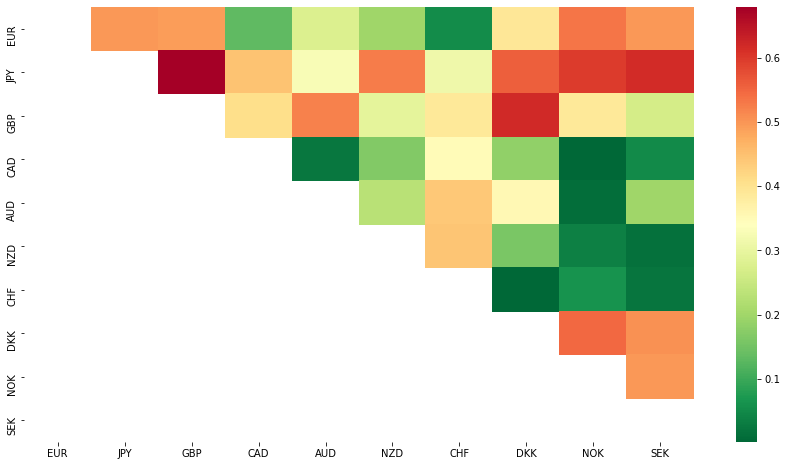

In [9]:
seaborn.heatmap(pvalues, xticklabels=namelist,
                yticklabels=namelist, cmap='RdYlGn_r',
                mask = (pvalues >= 0.98))
plt.show()

### 1.2 List of pairs filtered for Pair Trading Strategy

In [10]:
pairs

[('EUR', 'CHF'),
 ('CAD', 'AUD'),
 ('CAD', 'NOK'),
 ('CAD', 'SEK'),
 ('AUD', 'NOK'),
 ('NZD', 'NOK'),
 ('NZD', 'SEK'),
 ('CHF', 'DKK'),
 ('CHF', 'NOK'),
 ('CHF', 'SEK')]

### 1.3 Function to generate Pair Trading strategy

In [11]:
def trade(S1, S2, indexS1, indexS2, window1, window2):
    MAX_HOLD = 5 # maximum position

    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    
    money = [0] * len(ratios)
    value = [0] * len(ratios)
    countS1 = 0
    countS2 = 0
    sig = [[0] * 10 for _ in range(len(ratios))]  # log the operation signal.
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1 and countS1 > -MAX_HOLD:
                countS1 -= 1
                countS2 += ratios[i]
                sig[i][indexS1] = -1
                sig[i][indexS2] = ratios[i]
                money[i]-=S1[i]*TRANS_FEE*1+abs(ratios[i])*S2[i]*TRANS_FEE #long 1 short 1, 2 transaction fees
        # Buy long if the z-score is < 1
        elif zscore[i] < -1 and countS1 < MAX_HOLD:
                countS1 += 1
                countS2 -= ratios[i]
                sig[i][indexS1] = 1
                sig[i][indexS2] = -ratios[i]
                money[i]-=S1[i]*TRANS_FEE*1+abs(ratios[i])*S2[i]*TRANS_FEE #long 1 short 1, 2 transaction fees
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money[i] += countS1 * S1[i] + countS2 * S2[i]
            money[i] -= abs(countS1 * S1[i]) * TRANS_FEE + abs(countS2 * S2[i]) * TRANS_FEE
            sig[i][indexS1] = -countS1
            sig[i][indexS2] = -countS2
            countS1 = 0
            countS2 = 0
        # when it comes to the end, clear the position.
        if i == len(S1)-1:
            money[i] += countS1 * S1[i] + countS2 * S2[i]
            money[i] -= abs(countS1 * S1[i])*TRANS_FEE+abs(countS2 * S2[i])*TRANS_FEE
            sig[i][indexS1] = -countS1
            sig[i][indexS2] = -countS2
            countS1 = 0
            countS2 = 0

        value[i] = countS1 * S1[i] + countS2 * S2[i]

    money = np.array(money)
    money = np.cumsum(money) # money we earn
    value = np.array(value)
    value = money + value
    value = pd.Series(value, index=ratios.index)
    sig = pd.DataFrame(sig,index = S1.index,columns=namelist)

    return value, sig

### 1.4 Plot chart for all currency pairs in Pair Trading

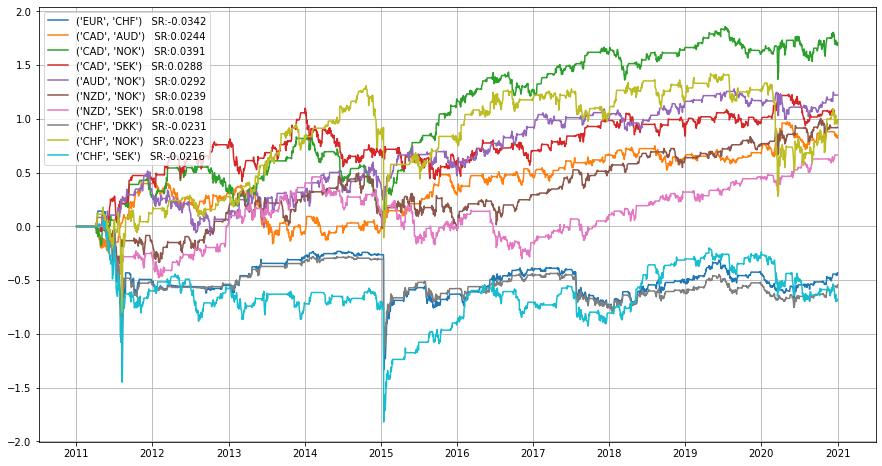

In [12]:
pnl_series=[]
sharpe_series={}
pairs_pnl=[0]*N
signal = pd.DataFrame([[0]*10 for _ in range(N)],index=base.index,columns=namelist)

# plot all pairs
for i in range(len(pairs)):
    indexS1 = namelist.index(pairs[i][0])
    indexS2 = namelist.index(pairs[i][1])
    pnl,temp = trade(s_rate[pairs[i][0]].iloc[:N],
                     s_rate[pairs[i][1]].iloc[:N],indexS1,indexS2,5, 60)
    signal += temp
    pairs_pnl=list(map(lambda x,y:x+y,pnl,pairs_pnl))
    pnl.index = pd.to_datetime(pnl.index)

    return_pnl = np.array((pnl+1).diff(1)[1:])/np.array((pnl[:-1]+1))
    sharpe_ratio = return_pnl.mean()/return_pnl.std()
    pnl_series.append(return_pnl)
    sharpe_series[pairs[i]]=sharpe_ratio
    plt.plot(pnl,label=str(pairs[i])+'   SR:'+str(round(sharpe_ratio,4)))

plt.legend()
plt.show()

### 1.5 Plot chart for total Pair Trading strategy

return: 5.6281
sharpe ratio: 0.0198


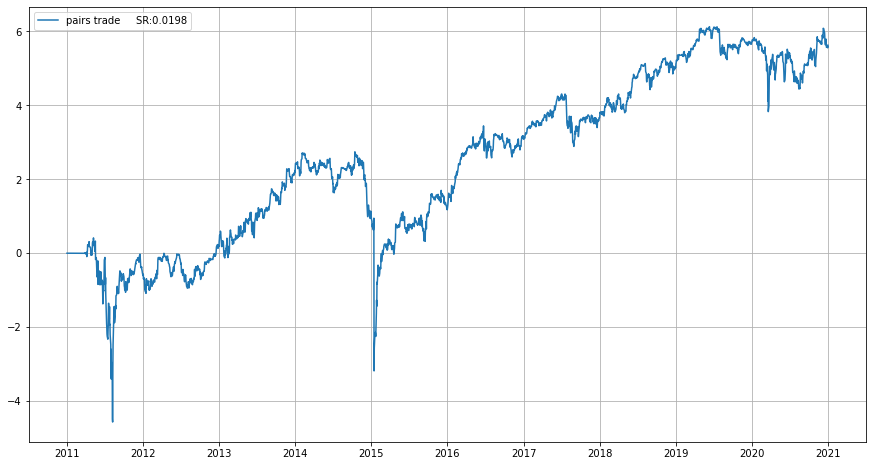

In [13]:
pairs_pnl = pd.Series(pairs_pnl,index=base.index)

return_pairs_pnl = np.array((pairs_pnl+10).diff(1)[1:])/np.array((pairs_pnl[:-1]+10))
sharpe_ratio_pairs = return_pairs_pnl.mean()/return_pairs_pnl.std()

pairs_pnl.index = pd.to_datetime(pairs_pnl.index)

print ("return: %.4f" %(round(pairs_pnl[-1],4)))
print ("sharpe ratio: %.4f" %(round(sharpe_ratio_pairs,4)))
plt.plot(pairs_pnl,label='pairs trade     SR:'+str(round(sharpe_ratio_pairs,4)))
plt.legend()
plt.show()

## Strategy 2 : Carry Trade

### 2.1 Generate Portfolio and Derive Interest Rate

In [14]:
class Portfolio:
    def __init__(self,length):
        self.long=[[10,0,0],[10,0,0]] #currency index, open price, quantity, 10 represents closed position
        self.short=[[10,0,0],[10,0,0]]
        self.long_history=np.zeros((length,10))    #the history of position
        self.short_history=np.zeros((length,10)) 
        self.value=0
        self.value_track=[0]
        self.returns=[]
        self.status="closed"
    def reset_longshort(self):
        self.long=[[10,0,0],[10,0,0]] 
        self.short=[[10,0,0],[10,0,0]]
        self.status="closed"

def get_rate(s,row_n):  #get excess rate
    return np.array([np.log(s[i].iloc[row_n,1]) for i in range(10)])

def gen_portfolio(s, f): #s:spot rate; f:1m forward rate
    p1,p2,p3,p4,p5=[],[],[],[],[]
    length=len(s[0])
    for d in range(length):
        spot_list=[]
        forward_list=[]
        for cur in range(10):
            spot_list.append(s[cur].iat[d,1])
            forward_list.append(f[cur].iat[d,1])
        forward_premium=list(map(sub,np.log(forward_list),np.log(spot_list)))
        forward_premium_sort=np.argsort(forward_premium)
        p5.append([forward_premium_sort[0],forward_premium_sort[1]])
        p4.append([forward_premium_sort[2],forward_premium_sort[3]])
        p3.append([forward_premium_sort[4],forward_premium_sort[5]])
        p2.append([forward_premium_sort[6],forward_premium_sort[7]])
        p1.append([forward_premium_sort[8],forward_premium_sort[9]])
        p=(p1,p2,p3,p4,p5)
    return p

def cal_mv(s,f,D=21):   
    mv=[]
    length=len(s[0])
    m=s[0].iat[0,0].month    # monthly rebalancing
    mv_n=0
    for d in range(2,length):
        if s[0].iat[d,0].month!=m:
            mv.append(mv_n)
            mv_n=0
        r=get_rate(s,d)-get_rate(f,d-1)
        r_lag=get_rate(s,d-1)-get_rate(f,d-2)
        mv_n+=sum(r**2+2*r*r_lag)/100
        m=s[0].iat[d,0].month
    return mv

### 2.2 Function to Generate Open and Close Position

In [15]:
def close_pos(port,d,s,f,p1,p5): #return value brought by closing position
    long_value=s[port.long[0][0]].iat[d,1]*port.long[0][2]+s[port.long[1][0]].iat[d,1]*port.long[1][2]
    short_value=s[port.short[0][0]].iat[d,1]*port.short[0][2]+s[port.short[1][0]].iat[d,1]*port.short[1][2]
    port.long_history[d,port.long[0][0]]-=port.long[0][2]
    port.long_history[d,port.long[1][0]]-=port.long[1][2]
    port.short_history[d,port.short[0][0]]-=port.short[0][2]
    port.short_history[d,port.short[1][0]]-=port.short[1][2]
    port.value=long_value+short_value
    port.value_track.append(port.value)
    if (port.value_track[-2])!=0:
        port.returns.append(port.value_track[-1]/port.value_track[-2]-1)
    port.reset_longshort()
    return port
    
def open_pos(port,d,s,f,p1,p5): #opening position
    port.long=[[p1[d][0],s[p1[d][0]].iat[d,1],1/s[p1[d][0]].iat[d,1]],[p1[d][1],s[p1[d][1]].iat[d,1],1/s[p1[d][1]].iat[d,1]]]
    port.short=[[p5[d][0],s[p5[d][0]].iat[d,1],-1/s[p5[d][0]].iat[d,1]],[p5[d][1],s[p5[d][1]].iat[d,1],-1/s[p5[d][1]].iat[d,1]]]
    port.long_history[d,p1[d][0]]+=1/s[p1[d][0]].iat[d,1]    #record position
    port.long_history[d,p1[d][1]]+=1/s[p1[d][1]].iat[d,1]
    port.short_history[d,p5[d][0]]-=1/s[p5[d][0]].iat[d,1]
    port.short_history[d,p5[d][1]]-=1/s[p5[d][1]].iat[d,1]
    port.status="open"
    return port

### 2.3 Function to generate Carry Trade Strategy

In [16]:
def t_strategy(t,s,f,mv,p): #implement carry trade strategy
    p1,p2,p3,p4,p5=p
    length=len(s[0])
    port=Portfolio(length)
    port=open_pos(port,0,s,f,p1,p5)    
    d=0
    m=0
    while m<11:
        d+=1
        if s[0].iat[d,0].month!=s[0].iat[d-1,0].month:
            m+=1
            if port.status=="open":
                port=close_pos(port,d,s,f,p1,p5)
                port=open_pos(port,d,s,f,p1,p5)
    while d<length-2:
        d+=1
        if s[0].iat[d,0].month!=s[0].iat[d-1,0].month:
            m+=1
            t_indicator_1=port.returns[-1]<np.percentile(port.returns,t)
            t_indicator_2=mv[m-1]>np.percentile(mv[:m-1],50)
            t_indicator=(t_indicator_1 and t_indicator_2)   #critical indicators (t quantile and mv), please refer to the summary paper
            if (t_indicator and (port.status=="open")):
                port=close_pos(port,d,s,f,p1,p5)
            elif ((not t_indicator) and (port.status=="open")):
                port=close_pos(port,d,s,f,p1,p5)
                port=open_pos(port,d,s,f,p1,p5)
            elif ((not t_indicator) and (port.status=="closed")):
                port.value_track.append(0)
                port=open_pos(port,d,s,f,p1,p5)
            elif (t_indicator and (port.status=="closed")):
                port.value_track.append(0)
    if port.status=="open":
        d+=1
        port=close_pos(port,d,s,f,p1,p5)
    return port

def output_pos(port,s,cur):     #ouput position information
    history_sum=port.long_history+port.short_history
    history_sum=pd.DataFrame(history_sum,index=s[0]["DATE"],columns=cur)
    history_sum.to_csv("t-quantile.csv")   #unquote to output position information 
    return history_sum

### 2.4 Plot chart for Carry Trade

return: 0.4504
sharpe ratio: 0.0176


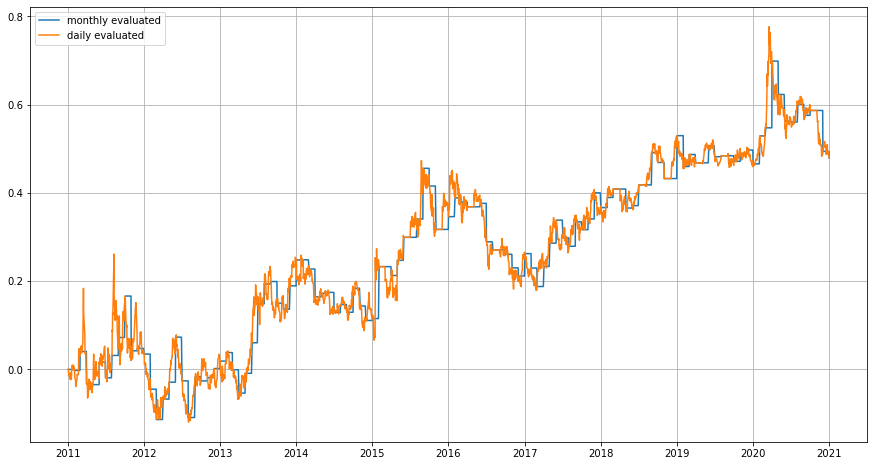

In [17]:
def cal_sharpe(history_sum,total_cf_allq,s):        #calculate sharpe ratio and plot daily values
    s_sum=s[0]
    for i in range(1,10):
        s_sum[s[i].columns.values.tolist()[1]]=s[i].iloc[:,1]
    s_sum=s_sum.set_index(["DATE"])
    history_cumsum=history_sum.cumsum()
    mark_to_market=history_cumsum*s_sum
    mark_to_market=mark_to_market.sum(axis=1)
    mark_to_market=mark_to_market+total_cf_allq
    plt.plot(mark_to_market-1,label="daily evaluated")
    mark_to_market=mark_to_market+1
    mark_to_market=mark_to_market.pct_change()[1:]
    return mark_to_market.mean()/mark_to_market.std()

def plot_pos(history_sum,s):   
    s_sum=s[0]
    for i in range(1,10):
        s_sum[s[i].columns.values.tolist()[1]]=s[i].iloc[:,1]
    s_sum=s_sum.set_index(["DATE"])
    total_cf=history_sum*-s_sum
    total_cf_allq=total_cf.sum(axis=1)
    total_cf_allq=total_cf_allq.cumsum()
    total_cf_allq += 1
    plt.plot(total_cf_allq-1,label="monthly evaluated")
    return total_cf_allq

cur=['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF', 'DKK', 'NOK', 'SEK']
s,f=import_pd(cur)
p=gen_portfolio(s, f)
mv=cal_mv(s,f)
t=50

port=t_strategy(t,s,f,mv,p)
pnl = np.array(port.value_track)
pnl = pnl.cumsum()
history_sum=output_pos(port,s,cur)
total_cf_allq=plot_pos(history_sum,s)

t_strategy = history_sum
t_strategy_value_signal = t_strategy.cumsum()

t_strategy_money = t_strategy*-s_rate   
t_strategy_money = t_strategy_money.sum(axis=1)-abs(t_strategy*s_rate*TRANS_FEE).sum(axis=1)
t_strategy_money = t_strategy_money.cumsum()

t_strategy_valule = t_strategy_value_signal*s_rate
t_strategy_valule = t_strategy_valule.sum(axis=1)

t_strategy_pnl = t_strategy_money+t_strategy_valule

print ("return: %.4f" %(t_strategy_pnl[-1]))
print ("sharpe ratio: %.4f" %(cal_sharpe(history_sum,total_cf_allq,s)))
t_strategy_pnl.index = pd.to_datetime(t_strategy_pnl.index)
plt.legend()
plt.show()

## Strategy 3 : Time Series Momentum

### 3.1 Function to generate Trend Signal 

In [18]:
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))
    return np.clip(t_stat, a_max=5, a_min=-5)

### 3.2 Function to obtain volatility

In [19]:
def GetYZVolatility(portfolio_Currency_list,current_date,all_df):

    """ Formula: sigma_YZ^2 = sigma_OJ^2 + self.k * sigma_SD^2 + (1-self.k)*sigma_RS^2 (Equation 20 in [1])
        where,  sigma_OJ - (Overnight Jump Volitility estimator)
                sigma_SD - (Standard Volitility estimator)
                sigma_RS - (Rogers and Satchell Range Volatility estimator)"""  

    YZ_volatility = []

    for i  in portfolio_Currency_list:
        
        today = current_date
        
        diff = pd.to_datetime(pd.to_datetime(pd.to_datetime(today) - timedelta(59))).strftime('%Y-%m-%d')
    
        for k in range (1,10,1):
            if (diff in all_df[i].index):
                break;
            else:
                diff = pd.to_datetime(pd.to_datetime(pd.to_datetime(today) - timedelta(59-k))).strftime('%Y-%m-%d')

        all_df[i] =  all_df[i].sort_index()

        past_month_ohlc = all_df[i].loc[diff:today]

        high,low,close,open = past_month_ohlc.High,past_month_ohlc.Low, past_month_ohlc.Last,past_month_ohlc.Last

        estimation_period = past_month_ohlc.shape[0]
        k = 0.34 / (1.34 + (estimation_period + 1) / (estimation_period - 1))

        open_to_close_log_returns = np.log(close / close.shift(1))
        open_to_close_log_returns = open_to_close_log_returns.dropna()

        open_to_close_log_returns = open_to_close_log_returns[np.isfinite(open_to_close_log_returns)]
        sigma_OJ = np.std(open_to_close_log_returns)
        close_to_close_log_returns = np.log(close / close.shift(1))
        close_to_close_log_returns  = close_to_close_log_returns.dropna()
        close_to_close_log_returns = close_to_close_log_returns[np.isfinite(close_to_close_log_returns)]
        sigma_SD = np.std(close_to_close_log_returns)

        h = np.log(high / open)
        l = np.log(low / open)
        c = np.log(close / open)
        sigma_RS_daily = (h * (h - c) + l * (l - c)) ** 0.5
        sigma_RS_daily = sigma_RS_daily[np.isfinite(sigma_RS_daily)]
        sigma_RS = np.mean(sigma_RS_daily)

        # daily Yang and Zhang volatility
        sigma_YZ = np.sqrt(sigma_OJ ** 2 + k * sigma_SD ** 2 + (1 - k) * sigma_RS ** 2)

        YZ_volatility.append(sigma_YZ * np.sqrt(252))
  
    return YZ_volatility

In [20]:
def GetCorrelationFactor(close_df,trade_signals,available_symbols):
    '''
    Correlation Factor, is a function of the average pairwise correlation of all portfolio contituents
    - the calculation is based on past three month pairwise correlation
    - Notations:
        rho_bar - average pairwise correlation of all portfolio constituents
        CF_rho_bar - the correlation factor as a function of rho_bar'''

    # Get the past three month simple daily returns for all securities
    diff = pd.to_datetime(pd.to_datetime(close_df.index[-1]) - timedelta(120)).strftime('%Y-%m-%d')
    past_three_month_returns = close_df.pct_change().loc[diff:]
    past_three_month_returns.corr()
    
    # Get number of assets 
    N_assets = len(available_symbols)

    # Get the pairwise signed correlation matrix for all assets
    correlation_matrix = past_three_month_returns.corr()

    # Calculate rho_bar
    summation = 0
    for i in range(N_assets - 1):
        for temp in range(N_assets - 1 - i):
            j = i + temp + 1
            x_i = trade_signals.values[i]
            x_j = trade_signals.values[j]
            rho_i_j = correlation_matrix.iloc[i, j]
            summation += x_i * x_j * rho_i_j

    rho_bar = (2 * summation) / (N_assets * (N_assets - 1))

    # Calculate the correlation factor (CF_rho_bar)
    return np.sqrt(N_assets / (1 + (N_assets - 1) * rho_bar)) 

### 3.3 Function to generate portfolio weights for different currency  
-  weights allocation is based on  volaiity 
-  Also have considered correlation factor 

In [21]:
def Portfolio_Creation(close_df,current_date,all_df,portfolio_target_sigma):
   
    N_assets = len(close_df)
    AssetWeight = []

    trade_signals = GetTradingSignal(close_df.loc[:current_date])
    currency = pd.DataFrame(GetTradingSignal(close_df.loc[:current_date]))
   
    TopCurrency = pd.DataFrame(currency).nlargest(3,currency.columns).abs() * (-1)
    
    BottomCurrency = pd.DataFrame(currency).nsmallest(3,currency.columns).abs() * (1)

    list_FX_Pairs_Portfolio = list(pd.concat([TopCurrency , BottomCurrency]).index)
    
    volatility =  GetYZVolatility(list_FX_Pairs_Portfolio,current_date,all_df)

    close_df = close_df[list_FX_Pairs_Portfolio]
    trade_signals = pd.concat([TopCurrency , BottomCurrency])
        
    # Get the correlation factor
    CF_rho_bar = GetCorrelationFactor(close_df, trade_signals, list_FX_Pairs_Portfolio)

    # Rebalance the portfolio according to Baltas and Kosowski suggested weights
    N_assets = len(list_FX_Pairs_Portfolio)
    final_Normalized_weight = {}
    Volatility_weight  = {}
    
    for symbol, signal, vol in zip(list_FX_Pairs_Portfolio, trade_signals.values, volatility):
        # Baltas and Kosowski weights (Equation 19 in [1])
        weight = (signal * portfolio_target_sigma * CF_rho_bar) / (N_assets * vol)
        Volatility_weight[symbol] = weight


    p1 = cp.Variable() # Long FX -1 
    p2 = cp.Variable() #  Long FX  -2
    p3 = cp.Variable() #  Long FX  -3
    p4 = cp.Variable() #  Short FX -4
    p5 = cp.Variable() #  Short FX  -5
    p6 = cp.Variable() #  Short FX  -6
    
    # Volatility weight
    Volatility_weight = pd.DataFrame.from_dict(Volatility_weight)
    Volatility_weight = Volatility_weight.sort_values(by = Volatility_weight.columns[0],ascending=False)

    
    constraints = [p1 >= 0, p2 >= 0, p3 >= 0, p4 >= 0, p5>=0, p6>=0,\
                   p1 <= 0.5, p2 <= 0.5, p3 <= 0.5, p4 <= 0.5, p5<=0.5, p6<=0.5,\
                   
                   p1 + p2 + p3 +( p4 + p5 + p6 )== 1,
                  sum([p1*Volatility_weight.iloc[0][0], p2*Volatility_weight.iloc[0][1],\
                                    p3*Volatility_weight.iloc[0][2], p4*Volatility_weight.iloc[0][3],\
                                    p5*Volatility_weight.iloc[0][4], p6*Volatility_weight.iloc[0][5]])==0\
                    ]

    obj = cp.Maximize(sum([p1*Volatility_weight.iloc[0][0], p2*Volatility_weight.iloc[0][1],\
                                    p3*Volatility_weight.iloc[0][2], p4*Volatility_weight.iloc[0][3],\
                                    p5*Volatility_weight.iloc[0][4], p6*Volatility_weight.iloc[0][5]\
                                   ]))
            
    prob = cp.Problem(obj, constraints)
 
    try:
        prob.solve()
        p1_weight = p1.value*Volatility_weight.iloc[0][0] *100
        p2_weight = p2.value*Volatility_weight.iloc[0][1] *100
        p3_weight = p3.value*Volatility_weight.iloc[0][2] *100
        p4_weight = p4.value*Volatility_weight.iloc[0][3] *100
        p5_weight = p5.value*Volatility_weight.iloc[0][4] *100
        p6_weight = p6.value*Volatility_weight.iloc[0][5] *100
    except SolverError:
        prob.solve(solver=SCS)
        p1_weight = p1.value*Volatility_weight.iloc[0][0] *100
        p2_weight = p2.value*Volatility_weight.iloc[0][1] *100
        p3_weight = p3.value*Volatility_weight.iloc[0][2] *100
        p4_weight = p4.value*Volatility_weight.iloc[0][3] *100
        p5_weight = p5.value*Volatility_weight.iloc[0][4] *100
        p6_weight = p6.value*Volatility_weight.iloc[0][5] *100

    Volatility_weight_values = pd.DataFrame.from_dict(Volatility_weight).values.reshape(-1,1)

    return {"Currency":Volatility_weight.columns,"Weight":[p1_weight,p2_weight,p3_weight,p4_weight,p5_weight,p6_weight]}

### 3.4 Weights Allocated to different Currencies : T =0 

In [22]:
FX_SEK = pd.read_csv("FX_SEK.csv", skiprows=0, index_col ="Dates")
FX_DKK = pd.read_csv("FX_DKK.csv", skiprows=0, index_col ="Dates")
FX_CHF = pd.read_csv("FX_CHF.csv", skiprows=0, index_col ="Dates")
FX_NZD = pd.read_csv("FX_NZD.csv", skiprows=0, index_col ="Dates")
FX_AUD = pd.read_csv("FX_AUD.csv", skiprows=0, index_col ="Dates")
FX_CAD=  pd.read_csv("FX_CAD.csv", skiprows=0, index_col ="Dates")
FX_GBP=  pd.read_csv("FX_GBP.csv", skiprows=0, index_col ="Dates")
FX_JPY = pd.read_csv("FX_JPY.csv", skiprows=0, index_col ="Dates")
FX_EUR = pd.read_csv("FX_EUR.csv", skiprows=0, index_col ="Dates")

FX_CAD.index = pd.to_datetime(FX_CAD.index)
FX_CAD = FX_CAD[["High","Low","Last"]]
FX_NZD.index = pd.to_datetime(FX_CAD.index)
FX_NZD = FX_NZD [["High","Low","Last"]]
FX_SEK.index = pd.to_datetime(FX_CAD.index)
FX_SEK = FX_SEK [["High","Low","Last"]]
FX_DKK .index = pd.to_datetime(FX_CAD.index)
FX_DKK  = FX_DKK[["High","Low","Last"]]
FX_CHF.index = pd.to_datetime(FX_CAD.index)
FX_CHF = FX_CHF[["High","Low","Last"]]
FX_NZD.index = pd.to_datetime(FX_CAD.index)
FX_NZD = FX_NZD[["High","Low","Last"]]
FX_AUD.index = pd.to_datetime(FX_CAD.index)
FX_AUD = FX_AUD[["High","Low","Last"]]
FX_GBP.index = pd.to_datetime(FX_CAD.index)
FX_GBP = FX_GBP[["High","Low","Last"]]
FX_JPY.index = pd.to_datetime(FX_CAD.index)
FX_JPY = FX_JPY[["High","Low","Last"]]
FX_EUR.index = pd.to_datetime(FX_CAD.index)
FX_EUR = FX_EUR[["High","Low","Last"]]
for i in [FX_SEK,FX_DKK,FX_CHF,FX_NZD,FX_AUD,FX_CAD,FX_JPY,FX_EUR]:
    i.index = pd.to_datetime(i.index)
    i.sort_index(ascending = True, inplace = True)    

FX_DKK_Last = pd.DataFrame(FX_DKK["Last"])
FX_SEK_Last = pd.DataFrame(FX_SEK["Last"])
FX_CHF_Last = pd.DataFrame(FX_CHF["Last"])
FX_NZD_Last = pd.DataFrame(FX_NZD["Last"])
FX_CAD_Last = pd.DataFrame(FX_CAD["Last"])
FX_AUD_Last = pd.DataFrame(FX_AUD["Last"])
FX_JPY_Last = pd.DataFrame(FX_JPY["Last"])
FX_GBP_Last = pd.DataFrame(FX_GBP["Last"])
FX_EUR_Last = pd.DataFrame(FX_EUR["Last"])

Close_mom_df =pd.concat([FX_DKK_Last,FX_SEK_Last,FX_CHF_Last, \
                                FX_CAD_Last,FX_NZD_Last,\
                                FX_AUD_Last,FX_JPY_Last,FX_GBP_Last,FX_EUR_Last],axis =1)
Close_mom_df.columns = ["FX_DKK","FX_SEK","FX_CHF","FX_NZD","FX_CAD","FX_AUD","FX_JPY","FX_GBP","FX_EUR"]
available_symbols = Close_mom_df.columns

In [23]:
def MomentumStrategy(Close_mom_df):
    offset = BQuarterEnd()
    offset1 = BMonthEnd()
    cumulative_mom_PNL_ALL = dict()
    weight_df = {}
    cumulative_mom_PNL_ALL = {}
    pct_change_value = pd.DataFrame()
    position =0
    total_PNL = 0
    Close_mom_df = Close_mom_df
    start_count =0
    smallest_year_count =1
    skip_rebalancing =0
    pnl_ = dict()
    for i in Close_mom_df.index.year.unique():
        rebalancing_count_year =0
        if ( i == 2021):
            break
            
        pct_change_value = pd.DataFrame()
        ## all_DF _ high , low . close
        all_df = {'FX_CAD':FX_CAD,\
                      'FX_NZD':FX_NZD,\
                      'FX_SEK':FX_SEK, \
                      'FX_DKK':FX_DKK, \
                      'FX_CHF':FX_CHF,\
                      'FX_NZD':FX_NZD,\
                      'FX_AUD':FX_AUD,\
                      'FX_GBP':FX_GBP,\
                      'FX_JPY':FX_JPY,\
                      'FX_EUR':FX_EUR}

        Close_momm_year  = Close_mom_df[Close_mom_df.index.year == i]
        Close_momm_year = Close_momm_year.sort_index(ascending = True)

        offset = BQuarterEnd()

        y_date = offset.rollforward(Close_momm_year.sort_index().index[0])

        Close_momm_year = Close_momm_year.sort_index(ascending = True)

        if smallest_year_count ==1:

            FX_Weights = Portfolio_Creation(Close_mom_df.loc[:y_date].\
                                                    sort_index(),y_date,all_df,0.4)
            smallest_year_count=0
            ilocstart =90
        
        else:

            dt = str(pd.DataFrame(Close_momm_year.iloc[0]).columns[0]).replace("00:00:00","").strip()
            FX_Weights = Portfolio_Creation(Close_mom_df.loc[: dt].\
                                                    sort_index(),dt,all_df,0.4)
            ilocstart =3

        weight_mom_df = pd.DataFrame(FX_Weights['Weight'],index = FX_Weights['Currency'])
        
        PNL_return = pd.DataFrame()
        PNL_return.drop(PNL_return.index, axis =0,inplace=True)
        Starting_day =0

        c =ilocstart
        while c in range(ilocstart,len(Close_momm_year)+1):
            
            if ( Starting_day > 0  ):

                length_df = len(Close_momm_year.iloc[Starting_day-2:c])

                P_change = Close_momm_year.iloc[Starting_day-2:c].pct_change(length_df-1).dropna()

            else:

                P_change = Close_momm_year.iloc[Starting_day:c].pct_change(c-1).dropna()
          
            pct_change_value = pd.concat([pct_change_value,P_change],ignore_index = False,axis =0)

            cumulative_momentum_PNL_df = pd.DataFrame()
            cumulative_momentum_PNL_df.drop(cumulative_momentum_PNL_df.index, axis =0,inplace=True)
            pct_change_value = pct_change_value.sort_index(ascending = True)
                       
            for j,t in enumerate (weight_mom_df.index):

                weight_mom_df.loc[t][0]
                cumulative_momentum_PNL_df["PNL_"+t] = P_change[t] * weight_mom_df.loc[t][0]
                
                if (j == len(weight_mom_df.index)-1):
                    cumulative_momentum_PNL_df["Portfolio_PNL"] = cumulative_momentum_PNL_df.sum(axis =1)
                    
            PNL_return = pd.concat([cumulative_momentum_PNL_df,PNL_return],ignore_index = False,axis =0)

            offset = BQuarterEnd() 
        
            if (((cumulative_momentum_PNL_df["Portfolio_PNL"][0] > 0) and (position == 1))):
                            previous_Value = cumulative_momentum_PNL_df["Portfolio_PNL"][0]
                            print("\n\n         ---------------------------------------------------------------")
                            date_pnl = str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip()
                            print("\n            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON {}".\
                                  format(date_pnl))
                            print("\n           ---------------------------------------------------------------")

                            print ('*1.Total investment  : \n ')
                            print (weight_mom_df)

                            print ("\n*2. Square off existing position and book profit")

                            print("\n*3.  PNL On Position {} : {}". \
                                  format( date_pnl,\
                                         cumulative_momentum_PNL_df["Portfolio_PNL"][0]))
                        
                            pnl_[date_pnl] =  \
                            {\
                             "Total_Running_PNL": total_PNL + cumulative_momentum_PNL_df["Portfolio_PNL"][0], \
                             "Portfolio_STD" : PNL_return["Portfolio_PNL"].std(),\
                             "Portfolio_Max" : PNL_return["Portfolio_PNL"].max(),\
                             "Portfolio_Min" : PNL_return["Portfolio_PNL"].min(),\
                             "Investment" : weight_mom_df,\
                             "PNL_on_current_position_Closure"  : cumulative_momentum_PNL_df["Portfolio_PNL"][0] \
                            }

                            total_PNL += pnl_[date_pnl]["PNL_on_current_position_Closure"]
                            print( "\n*4. Total portfolio PNL  {} ".format(total_PNL))
                            print("\n*8. OTHER STATS : \n")
                            print("\n * Portfolio Standard Deviation : {} ".format(PNL_return["Portfolio_PNL"].std()))
                            print("\n * Portfolio maximum return  : {} ".format(PNL_return["Portfolio_PNL"].max()))
                            print("\n * Portfolio minimum return  : {} ".format(PNL_return["Portfolio_PNL"].min()))

                            if (len(Close_momm_year) - c) > 20:
                                c = c+20
                            else:
                                c +=1
                            
                            Starting_day = c
                            position = 0
                            rebalancing_count_year= 1
            
            if (( (c >120) and (position == 1) and (rebalancing_count_year==0)) or  \
                 ((position == 1) and (str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip() == "2020-12-21"))):     
                    print("\n\n         ---------------------------------------------------------------")
                    date_pnl = str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip()
                    print("\n            PORTFOLIO REBALANCING : at end of  of {} using Past 90 days data".\
                          format(date_pnl))
                    print("\n           ---------------------------------------------------------------")
                    
                    print ('*1.Total investment  : \n ')
                    print (weight_mom_df)
                    print ("\n*2. Square off existing position and book profit")
                    print("\n*3. Portfolio PNL at end of  Month {} : {}". \
                          format( date_pnl,\
                                 cumulative_momentum_PNL_df["Portfolio_PNL"][0]))
                    pnl_[date_pnl] =  \
                    {\
                     "Total_Running_PNL": total_PNL + cumulative_momentum_PNL_df["Portfolio_PNL"][0], \
                     "Portfolio_STD" : PNL_return["Portfolio_PNL"].std(),\
                     "Portfolio_Max" : PNL_return["Portfolio_PNL"].max(),\
                     "Portfolio_Min" : PNL_return["Portfolio_PNL"].min(),\
                     "Investment" : weight_mom_df,\
                     "PNL_on_current_position_Closure"  : cumulative_momentum_PNL_df["Portfolio_PNL"][0] \
                    }
                    total_PNL += pnl_[date_pnl]["PNL_on_current_position_Closure"]
                    print( "\n*4. Total portfolio PNL  {} ".format(total_PNL))
                    
                    if (len(Close_momm_year) - c) > 20:

                                c = c+20
                    else:
                        c +=1
                    
                    position = 0
                    rebalancing_count_year= 1
                    Starting_day = c

            if (Close_mom_df.index.get_loc(cumulative_momentum_PNL_df.index[0]) <= 60 and start_count ==0):
                print("Condtionnot not matched {}".format(Close_mom_df.index. \
                                                          get_loc(cumulative_momentum_PNL_df.index[0])))
            
            elif ((position == 0 )): 

                        date_pnl = str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip()  

                        print("\n\n         ---------------------------------------------------------------")
                        print("\n*1.            PORTFOLIO CREATION :- {} using Past 90 days data".\
                              format(str(cumulative_momentum_PNL_df.index[0]).replace("00:00:00","").strip()))
                        print("\n          ---------------------------------------------------------------")
                        FX_Weights = Portfolio_Creation(Close_mom_df.loc[:cumulative_momentum_PNL_df.index[0]].\
                                                        sort_index(),cumulative_momentum_PNL_df.index[0],all_df,0.4)
  
                        weight_mom_df = pd.DataFrame(FX_Weights['Weight'],index = FX_Weights['Currency'])
                        print ( "\n* 2. POSITION ON DIFFERENT CURRENCIES : \n {}".format(weight_mom_df) )
                        print ("\n* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : {} ".\
                               format(weight_mom_df.sum()))
                
                        position = 1
                        c += 1
                        Starting_day = c
                        start_count =1
                        count =0
                        previous_Value = 0
                                        
            else:
                c += 1

    cumulative_mom_PNL_ALL[i] =  PNL_return

    return { "TOTAL_PNL"  : total_PNL ,"Details": pnl_ ,"PNL_DETAILS": cumulative_mom_PNL_ALL}

### 3.5 Execution of Momentum strategy

In [24]:
Close_mom_df = Close_mom_df.sort_index()
mom_  = MomentumStrategy(Close_mom_df)



         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2011-05-08 using Past 90 days data

          ---------------------------------------------------------------

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.654603
FX_CAD -0.567587
FX_JPY -0.704683
FX_SEK  0.474591
FX_NZD  0.338955
FX_GBP  1.113328

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0    6.172840e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2011-05-10

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.654603
FX_CAD -0.567587
FX_JPY -0.704683
FX_SEK  0.474591
FX_NZD  0.338955
FX_GBP  1.113328

*2. Square off existing position and book profit

*3.  PNL On Position 2011-05-10 : 0.043043685088651

*4. Total portfolio PNL  0.04304368508

         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2012-02-04

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -1.132896
FX_AUD -0.415821
FX_JPY -0.457658
FX_SEK  0.784993
FX_EUR  0.619818
FX_DKK  0.601564

*2. Square off existing position and book profit

*3.  PNL On Position 2012-02-04 : 0.03972815933305597

*4. Total portfolio PNL  0.46740433079598126 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.058454562858098004 

 * Portfolio maximum return  : 0.12239539490956876 

 * Portfolio minimum return  : 0.03972815933305597 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2012-02-04 using Past 90 days data

          ---------------------------------------------------------------

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_C


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CAD -1.230201
FX_JPY -0.535038
FX_AUD -0.446830
FX_DKK  0.819611
FX_EUR  0.808144
FX_SEK  0.584314

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -6.550316e-15
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2012-11-29

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -1.230201
FX_JPY -0.535038
FX_AUD -0.446830
FX_DKK  0.819611
FX_EUR  0.808144
FX_SEK  0.584314

*2. Square off existing position and book profit

*3.  PNL On Position 2012-11-29 : 0.0030433768509875014

*4. Total portfolio PNL  0.5593229097352406 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.036477379940537964 

 * Portfolio maximum return  : 0.12239539490956876 

 * Portfolio minimum return  : -0.06080256956693142 


         ----------------



         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2013-08-21

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -0.712659
FX_CHF -0.218598
FX_SEK -0.796378
FX_JPY  0.205952
FX_GBP  0.768832
FX_DKK  0.752852

*2. Square off existing position and book profit

*3.  PNL On Position 2013-08-21 : 0.008486711711936885

*4. Total portfolio PNL  0.717283368757298 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.03250420402370393 

 * Portfolio maximum return  : 0.08498765492036284 

 * Portfolio minimum return  : -0.11187261421269146 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2013-08-21 using Past 90 days data

          ---------------------------------------------------------------

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_



         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2014-01-09

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -1.127556
FX_CHF -0.714821
FX_GBP -0.553406
FX_JPY  0.884877
FX_AUD  0.675230
FX_NZD  0.835675

*2. Square off existing position and book profit

*3.  PNL On Position 2014-01-09 : 0.020982406906115674

*4. Total portfolio PNL  0.778511017548483 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.02901476495070293 

 * Portfolio maximum return  : 0.020982406906115674 

 * Portfolio minimum return  : -0.04775090908547613 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2014-01-09 using Past 90 days data

          ---------------------------------------------------------------

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CAD -1.167434
FX_GBP -0.080639
FX_CHF -0.013957
FX_JPY  0.303472
FX_NZD  0.463236
FX_SEK  0.495323

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -5.584422e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2014-12-02

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CAD -1.167434
FX_GBP -0.080639
FX_CHF -0.013957
FX_JPY  0.303472
FX_NZD  0.463236
FX_SEK  0.495323

*2. Square off existing position and book profit

*3.  PNL On Position 2014-12-02 : 0.022752219852422654

*4. Total portfolio PNL  0.9960632645461166 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.03185673525462519 

 * Portfolio maximum return  : 0.05144545455827805 

 * Portfolio minimum return  : -0.09881411695369602 


         ------------------


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.033111
FX_GBP -1.757283
FX_CAD -1.269680
FX_JPY  0.278277
FX_NZD  1.385220
FX_SEK  1.396578

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -3.845813e-13
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2015-06-05

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.033111
FX_GBP -1.757283
FX_CAD -1.269680
FX_JPY  0.278277
FX_NZD  1.385220
FX_SEK  1.396578

*2. Square off existing position and book profit

*3.  PNL On Position 2015-06-05 : 0.07249341054144232

*4. Total portfolio PNL  1.2322542285519547 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.053252618964670456 

 * Portfolio maximum return  : 0.07249341054144232 

 * Portfolio minimum return  : -0.16379303295008832 


         ------------------


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.160772
FX_GBP -1.368668
FX_CAD -1.166242
FX_JPY  0.279413
FX_NZD  1.216985
FX_AUD  1.199284

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -3.905765e-13
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2016-01-03

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.417596
FX_CAD -0.957496
FX_GBP -2.632518
FX_NZD  1.523669
FX_JPY  1.039826
FX_SEK  1.444115

*2. Square off existing position and book profit

*3.  PNL On Position 2016-01-03 : 0.25582496490368467

*4. Total portfolio PNL  1.6903166190767749 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : nan 

 * Portfolio maximum return  : 0.25582496490368467 

 * Portfolio minimum return  : 0.25582496490368467 


         ------------------------------------


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.422837
FX_CAD -0.584118
FX_JPY -1.221224
FX_NZD  0.616174
FX_SEK  0.779547
FX_AUD  0.832458

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -8.715251e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2016-09-28

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.422837
FX_CAD -0.584118
FX_JPY -1.221224
FX_NZD  0.616174
FX_SEK  0.779547
FX_AUD  0.832458

*2. Square off existing position and book profit

*3.  PNL On Position 2016-09-28 : 0.005455605143899174

*4. Total portfolio PNL  2.0284956629882176 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.12369297907934752 

 * Portfolio maximum return  : 0.25582496490368467 

 * Portfolio minimum return  : -0.379999671096082 


         --------------------

         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2017-06-01

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.722283
FX_CAD -1.285646
FX_DKK -1.954497
FX_NZD  1.321556
FX_JPY  1.326628
FX_SEK  1.314242

*2. Square off existing position and book profit

*3.  PNL On Position 2017-06-01 : 0.0023831430217712973

*4. Total portfolio PNL  2.2130288119289854 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.09368784635157765 

 * Portfolio maximum return  : 0.06586294308646762 

 * Portfolio minimum return  : -0.2604614447731474 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2017-06-01 using Past 90 days data

          ---------------------------------------------------------------

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_C

         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2017-12-09

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.924982
FX_CAD -0.799979
FX_AUD -3.796280
FX_NZD  1.978361
FX_SEK  1.631855
FX_JPY  1.911025

*2. Square off existing position and book profit

*3.  PNL On Position 2017-12-09 : 0.02888485045276666

*4. Total portfolio PNL  2.327741221156752 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.09491752339474721 

 * Portfolio maximum return  : 0.06586294308646762 

 * Portfolio minimum return  : -0.2604614447731474 


         ---------------------------------------------------------------

*1.            PORTFOLIO CREATION :- 2017-12-09 using Past 90 days data

          ---------------------------------------------------------------

* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF 


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.499533
FX_CAD -1.770163
FX_EUR -2.426385
FX_NZD  1.599336
FX_SEK  1.392794
FX_JPY  1.703952

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -2.908784e-14
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2018-09-05

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.499533
FX_CAD -1.770163
FX_EUR -2.426385
FX_NZD  1.599336
FX_SEK  1.392794
FX_JPY  1.703952

*2. Square off existing position and book profit

*3.  PNL On Position 2018-09-05 : 0.054862756252867184

*4. Total portfolio PNL  2.589859738466137 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.06913919649430454 

 * Portfolio maximum return  : 0.06168929573639202 

 * Portfolio minimum return  : -0.15624150386931757 


         -------------------


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.865435
FX_CAD -2.764042
FX_EUR -4.367545
FX_SEK  2.686646
FX_NZD  2.335140
FX_AUD  2.975237

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -5.329071e-15
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2019-05-11

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.865435
FX_CAD -2.764042
FX_EUR -4.367545
FX_SEK  2.686646
FX_NZD  2.335140
FX_AUD  2.975237

*2. Square off existing position and book profit

*3.  PNL On Position 2019-05-11 : 0.047318096896004636

*4. Total portfolio PNL  2.7779095298542424 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.05670883276180978 

 * Portfolio maximum return  : 0.06221890034492142 

 * Portfolio minimum return  : -0.11899343528833746 


         ------------------


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -1.002292
FX_CAD -3.738131
FX_EUR -4.033964
FX_SEK  2.855445
FX_NZD  2.631426
FX_AUD  3.287517

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0    4.440892e-16
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2020-01-05

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.763776
FX_CAD -3.993364
FX_GBP -2.347406
FX_SEK  2.477602
FX_NZD  2.177747
FX_AUD  2.449197

*2. Square off existing position and book profit

*3.  PNL On Position 2020-01-05 : 0.01832627162906686

*4. Total portfolio PNL  3.1679388741810013 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : nan 

 * Portfolio maximum return  : 0.01832627162906686 

 * Portfolio minimum return  : 0.01832627162906686 


         ------------------------------------


* 2. POSITION ON DIFFERENT CURRENCIES : 
                0
FX_CHF -0.173238
FX_CAD -1.114190
FX_DKK -1.927773
FX_NZD  1.136802
FX_SEK  1.057155
FX_AUD  1.021244

* 3. DOLLAR NEUTRAL STRATEGY : TOTAL INVESTMENT SUM IS   : 0   -7.993606e-15
dtype: float64 


         ---------------------------------------------------------------

            PORTFOLIO CLOSURE : HIGHEST EXPECTED RETURN ACHIEVED  : ON 2020-09-06

           ---------------------------------------------------------------
*1.Total investment  : 
 
               0
FX_CHF -0.173238
FX_CAD -1.114190
FX_DKK -1.927773
FX_NZD  1.136802
FX_SEK  1.057155
FX_AUD  1.021244

*2. Square off existing position and book profit

*3.  PNL On Position 2020-09-06 : 0.07751328360086915

*4. Total portfolio PNL  3.5347933198739674 

*8. OTHER STATS : 


 * Portfolio Standard Deviation : 0.05318567899892635 

 * Portfolio maximum return  : 0.13497996765263753 

 * Portfolio minimum return  : -0.07835619661712127 


         -------------------

### 3.6 Plot Momentum cummulative PnL

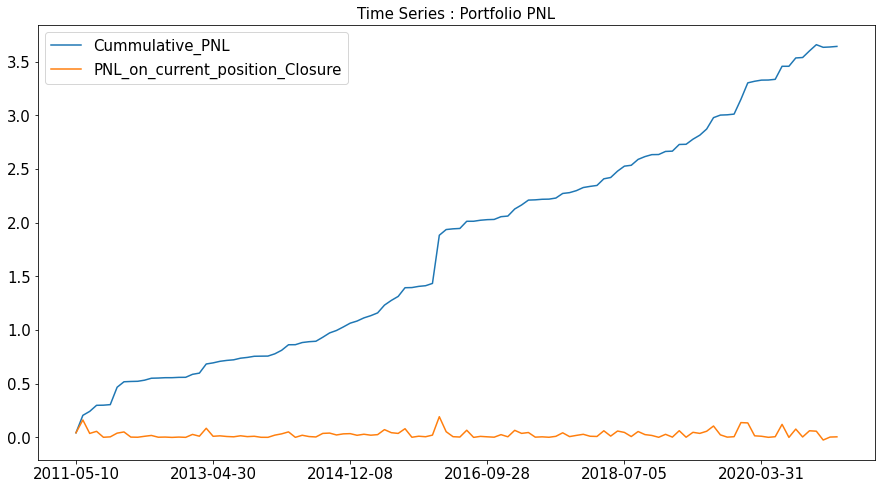

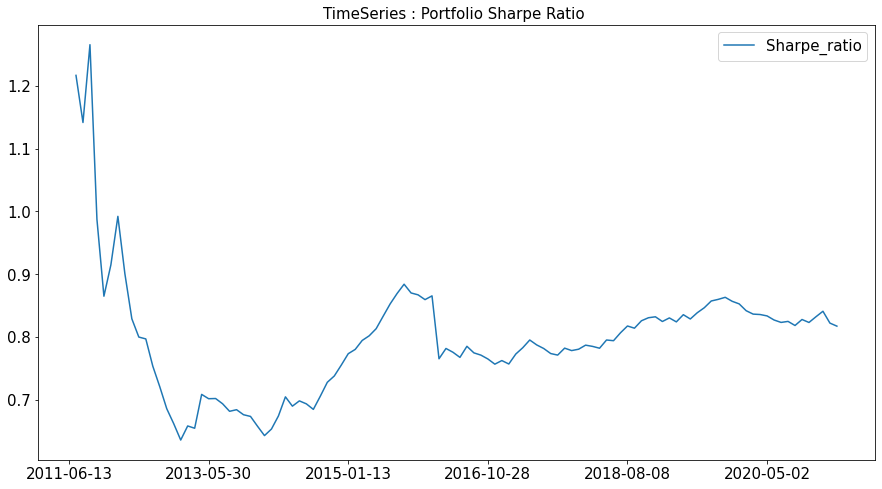

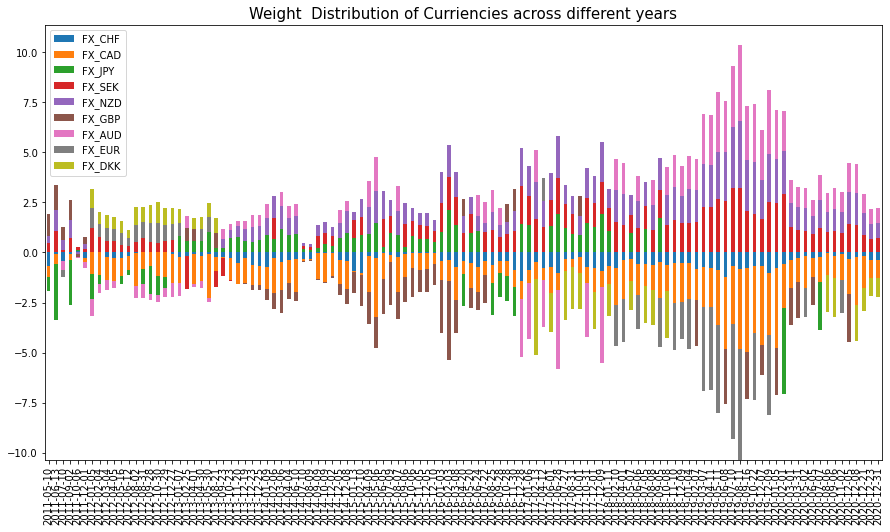

In [25]:
stats_ = dict()
for i,j in mom_["Details"].items():
    
    stats_[i] = {"Portfolio_STD": mom_["Details"][i]["Portfolio_STD"],  \
                 "PNL_on_current_position_Closure": mom_["Details"][i]["PNL_on_current_position_Closure"],\
                 "Cummulative_PNL" : mom_["Details"][i]["Total_Running_PNL"], \
                 "Portfolio_Max":    mom_["Details"][i]["Portfolio_Max"], \
                 "Portfolio_Min":    mom_["Details"][i]["Portfolio_Min"]}

PNL_ = pd.DataFrame.from_dict(stats_).T
PNL_all = PNL_ 

PNL_all = PNL_all[PNL_all.PNL_on_current_position_Closure!= 0].dropna(axis=0)
PNL_all.to_csv("PORTFOLIO_PNL.csv")
PNL_all[["Cummulative_PNL","PNL_on_current_position_Closure"]].plot()
plt.tick_params(labelsize=15)
plt.title("Time Series : Portfolio PNL",fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

## Sharpe Ratio
PNL_all.index = pd.to_datetime(PNL_all.index)
PNL_all = PNL_all[PNL_all.PNL_on_current_position_Closure !=0].dropna()
x = PNL_all[["PNL_on_current_position_Closure"]].pct_change().dropna()
sharpe_ratio = {}

for i in range(1,len(PNL_all)):
    _date = str(PNL_all.index[i]).replace("00:00:00","").strip() 
    _std = PNL_all["PNL_on_current_position_Closure"][0:i].std()
    _mean = PNL_all["PNL_on_current_position_Closure"][0:i].mean()
    sharpe_ratio[_date] = { "Sharpe_ratio" : _mean/_std}
    
pd.DataFrame(sharpe_ratio).T.plot( title = "TimeSeries : Portfolio Sharpe Ratio ")
plt.title("TimeSeries : Portfolio Sharpe Ratio ",fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

## weight 
investment = pd.DataFrame()
for i,j in mom_["Details"].items():
     df_ = pd.DataFrame(mom_['Details'][i]['Investment'].T.values, index = [i],  \
                        columns = mom_['Details'][i]['Investment'].T.columns )
     investment = pd.concat([investment,df_],ignore_index = False, axis =0)
    
investment = investment.fillna(0)
investment 

## Graph 
investment.plot(kind="bar",stacked=True,figsize=(15,8))
plt.title("Weight  Distribution of Curriencies across different years",fontsize=15)
plt.grid()
plt.show()

### 3.7 Print Sharpe ratio, Standard deviation, Mean return

In [26]:
PNL_all = PNL_all[PNL_all.PNL_on_current_position_Closure!= 0].dropna(axis=0)
sharp_ratio = PNL_all ["PNL_on_current_position_Closure"].iloc[1:].mean()/ PNL_all ["PNL_on_current_position_Closure"].iloc[1:].std()

print ("return: %.4f" %(PNL_all ["Cummulative_PNL"].iloc[-1]))
print ("sharpe ratio: %.4f" %(sharp_ratio))
PNL_all.to_csv("Cummulative_PNL_ER_greater_010.csv")

return: 3.6424
sharpe ratio: 0.8067


## Combined Strategies

In [27]:
"""combine three strategies """
money_signal = signal
value_signal = money_signal.cumsum()

combine_money_signal = money_signal+t_strategy #money is when you close the position what you earn from that
combine_value_signal = value_signal+t_strategy.cumsum() #value is that you hold a position, if the price change, the value of your protofilio will change

money_pnl = combine_money_signal*-s_rate   
money_pnl = money_pnl.sum(axis=1)-abs(combine_money_signal*s_rate*TRANS_FEE).sum(axis=1)
money_pnl = money_pnl.cumsum()

value_pnl = combine_value_signal*s_rate
value_pnl = value_pnl.sum(axis=1)

mom_pl = PNL_all["PNL_on_current_position_Closure"].iloc[1:]

money_w=money_pnl.std()/(money_pnl.std()+value_pnl.std()+mom_pl.std())
value_w=value_pnl.std()/(money_pnl.std()+value_pnl.std()+mom_pl.std())
mom_w=mom_pl.std()/(money_pnl.std()+value_pnl.std()+mom_pl.std())

Combined_pnl = money_pnl*money_w + value_pnl*value_w + mom_pl*mom_w

Combined_pnl.index = pd.to_datetime(Combined_pnl.index)

### Combined Strategies Performance Results

Transaction Fee: 0.0002
Pairs Trade return: 5.6281, Pairs Trade sharpe ratio: 0.0198
Carry Trade return: 0.4504, Carry Trade sharpe ratio: 0.0176
Momentum return: 3.6424, Momentum sharpe ratio: 0.8067
Combined Strategy return: 2.4471, Combined Strategy sharpe ratio: 1.4319


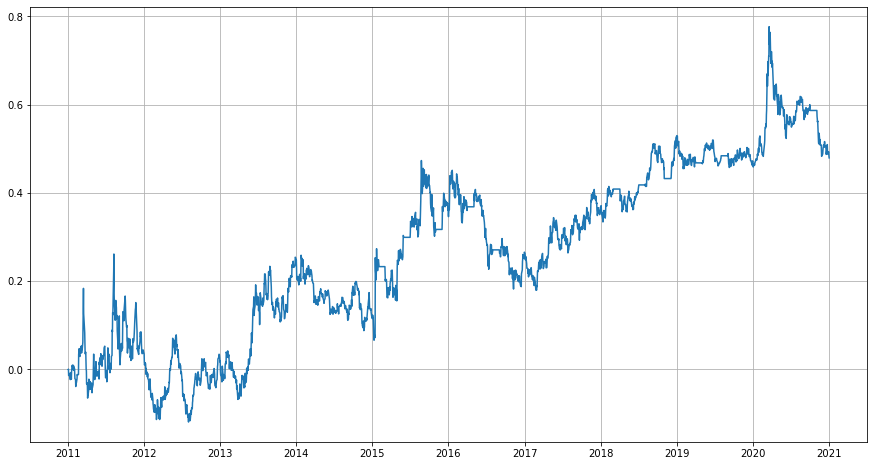

In [28]:
"""sharpe ratio""" 
print ("Transaction Fee: %.4f" %TRANS_FEE)
print ("Pairs Trade return: %.4f, Pairs Trade sharpe ratio: %.4f" %(pairs_pnl[-1],sharpe_ratio_pairs))
print ("Carry Trade return: %.4f, Carry Trade sharpe ratio: %.4f" %(t_strategy_pnl[-1], cal_sharpe(history_sum,total_cf_allq,s))) 
print ("Momentum return: %.4f, Momentum sharpe ratio: %.4f" %(PNL_all ["Cummulative_PNL"].iloc[-1], sharp_ratio)) 
print ("Combined Strategy return: %.4f, Combined Strategy sharpe ratio: %.4f" %(Combined_pnl.mean(),Combined_pnl.mean()/Combined_pnl.std()))